# Multilayer perceptron

In this section, I will develop a neural network that will take in previous words' embedding vector as input, concatenate these vectors into one long vector, and feed the resulting vector into subsequent neural network.

In [1]:
from my_utils import names, chars, c2i, i2c
import torch

In [23]:
n = 3

def sliding_window(name: str):
    context = [c2i['<s>']] * n
    Xs, Ys = [], []
    for y in list(name) + ['<e>']:
        Xs.append(context)
        Ys.append(c2i[y])
        context = context[1:]+[c2i[y]]

    return Xs, Ys

In [24]:
sliding_window(name='juhani')

([[0, 0, 0],
  [0, 0, 40],
  [0, 40, 33],
  [40, 33, 42],
  [33, 42, 31],
  [42, 31, 2],
  [31, 2, 45]],
 [40, 33, 42, 31, 2, 45, 46])

In [26]:
Xs, Ys = [], []
n = 3  # Similar to N in N-gram
for name in names:
    x, y = sliding_window(name=name)
    Xs.extend(x)
    Ys.extend(y)

Xs = torch.tensor(Xs)
Ys = torch.tensor(Ys)

print(f'{Xs.shape=},\n{Ys.shape=}')

Xs.shape=torch.Size([49084, 3]),
Ys.shape=torch.Size([49084])


In [27]:
import torch.nn.functional as F
Xenc = F.one_hot(Xs, num_classes=len(c2i)).float()

Xenc.shape
# (..., word_len, one_hot)

torch.Size([49084, 3, 47])

### Test run Forward-Backward

In [28]:
Xenc_sample = Xenc[:5,:,:]
Ys_sample = Ys[:5]

# Define layers
E = torch.randn(size=(47, 64), requires_grad=True)  # Embedding lookup matrix
W1 = torch.randn(size=(64*n, 64), requires_grad=True) # Hidden layer
O = torch.randn(size=(64, len(c2i)), requires_grad=True) # Output layer

# Forward pass
o1 = (Xenc_sample @ E).view(len(Xenc_sample), -1)
o2 = (o1 @ W1).tanh()
o3 = (o2 @ O).exp()
o3_denom = o3.sum(dim=-1, keepdim=True)
output = o3 / o3_denom

# Loss function: Negative Log-likehood
loss = -1 * output[ torch.arange(len(o3)) , Ys_sample].log()
reduced_loss = loss.mean()

reduced_loss.backward()

## Fully training

In [43]:
# Define layers
E = torch.randn((47, 128), requires_grad=True)  # Embedding lookup matrix
W1 = torch.randn((128*n, 64), requires_grad=True) # Hidden layer
b1 = torch.randn(64, requires_grad=True)
O = torch.randn((64, len(c2i)), requires_grad=True) # Output layer
b2 = torch.randn(len(c2i), requires_grad=True)

parameters = [E, W1, b1, O, b2]
total_loss = 0.0
losses = []

In [44]:
# Matrix multiplying one-hot with the embedding is equivalent to looking up.
(Xenc[0,0] @ E) == E[Xs[0,0]]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

In [45]:
for i in range(2000):

    Xenc_sample = Xenc
    Ys_sample = Ys

    # Forward pass
    o1 = (Xenc_sample @ E).view(len(Xenc_sample), -1)
    o2 = (o1 @ W1 + b1).tanh()
    logits = o2 @ O + b2
    loss = F.cross_entropy(logits, Ys_sample)
    total_loss += loss

    for parameter in parameters:
        parameter.grad = None
        
    loss.backward()

    lr = 1.0 if i < 300 else 0.1
    for parameter in parameters:
        parameter.data += -lr * parameter.grad

    if i % 100 == 0:
        print(f'{loss.item():.3f}')
    losses.append(loss.item())

16.894
7.054
5.287
4.492
4.025
3.684
3.454
3.271
3.133
3.022
2.927
2.854
2.782
2.725
2.675
2.632
2.602
2.598
2.594
2.590
2.587
2.583
2.579
2.576
2.572
2.569
2.565
2.562
2.558
2.555
2.551
2.548
2.545
2.541
2.538
2.535
2.532
2.529
2.526
2.523
2.520
2.517
2.515
2.512
2.509
2.506
2.504
2.501
2.498
2.496
2.493
2.490
2.488
2.485
2.483
2.480
2.477
2.475
2.472
2.470
2.467
2.465
2.463


KeyboardInterrupt: 

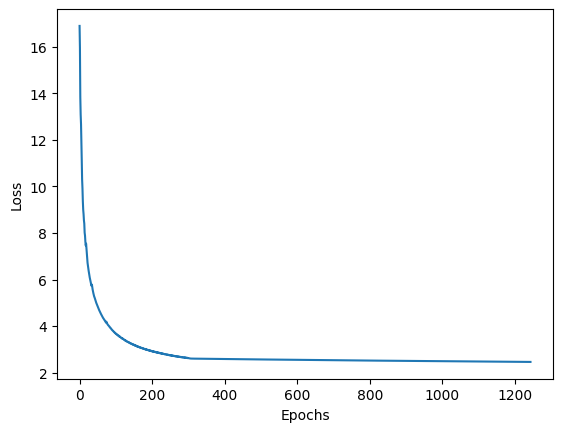

In [46]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(losses))), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Try generating

In [59]:
for _ in range(5):
    tokens = [c2i['<s>']] * n

    while True:
        recent_token = torch.tensor([tokens[-n:]])
        input_vector = F.one_hot(recent_token, num_classes=len(c2i)).float()

        o1 = (input_vector @ E).view(len(input_vector), -1)
        o2 = (o1 @ W1 + b1).tanh()
        logits_output = o2 @ O + b2
        counts_output = logits_output.exp()
        probs_output = counts_output / counts_output.sum(1, keepdims=True)

        next_idx = torch.multinomial(probs_output, num_samples = 1).item()
        tokens.append(next_idx)
        
        if i2c[next_idx] == '<e>':
            break

    print(''.join([i2c[i] for i in tokens][3:-1]))

roer
abdar
cetheía
sky
pus
